## Viewing the sat images and the mask ##

This set of code is for viewing the Sat images pre and post and showing the boxes around it

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
import json
import pathlib

In [6]:
xview_train_img_dir = "c:/data/xview2/train/images"
xview_train_json_dir = "c:/data/xview2/train/labels"
xview_train_mask_dir = "c:/data/xview2/train/mask1"

In [8]:
def show_pre_post(file, xview_train_img_dir, xview_train_json_dir):
    post_name = file + "_post_disaster"
    pre_name = file + "_pre_disaster"
    fig, ax = plt.subplots(1,2, figsize=(20,20))
    load_show(ax[0], xview_train_img_dir, xview_train_json_dir, pre_name)
    load_show(ax[1], xview_train_img_dir, xview_train_json_dir, post_name)
    plt.show()

def load_show(ax, img_path, json_path, name):
    image_path=os.path.join(img_path, name+".png")
    json_path = os.path.join(json_path, name+".json")
    j = json.loads(pathlib.Path(json_path).read_text())
    
    im = Image.open(image_path)
    
    #im.show()
    ax.imshow(im)
    
    polygons = extract_polygon(j)
    for p in polygons:
        ax.plot(p[0][0],p[0][1])

    
def plot_polygon(ax, x, y):
    ax.plot(x,y)
    
def extract_polygon(json):
    xy_f = json["features"]["xy"]
    results = []
    for i in xy_f:
        polygon_str = i["wkt"]
        r = decode_polygon(polygon_str)
        results.append((r, i)) if r is not "" else ""
    return results

def decode_polygon(polygon_str):
    if polygon_str.startswith("POLYGON"):
        replace_str = ["POLYGON", "((", "))", ","]
        for rs in replace_str:
            polygon_str = polygon_str.replace(rs,"")
        x_y = polygon_str.strip().split(" ")
        x = list(map(lambda x:float(x), x_y[0::2]))
        y = list(map(lambda x:float(x), x_y[1::2]))
        return [x,y]
    else:
        print("Unknown Shape")
        return ""
    
def create_mask(picture, polygons):
    im = Image.open(picture)
    np.array(im.size)
    
            
    
c = decode_polygon("POLYGON ((532.1863714054954 165.9824503000504, 548.6019827848852 224.1613082732768, 446.2458177229872 264.4761185678668, 440.6934785817455 249.7503495372735, 425.9677095499687 253.1300342329752, 420.8981825090282 232.3691139606, 437.5551999358392 227.0581808684396, 431.2786426428399 201.2277335525121, 532.1863714054954 165.9824503000504))")


In [ ]:
show_pre_post("guatemala-volcano_00000000", xview_train_img_dir, xview_train_json_dir)

In [ ]:
show_pre_post("hurricane-florence_00000199", xview_train_img_dir, xview_train_json_dir)

## Code for generating a mask ##

In [4]:
from skimage.draw import polygon 

def generate_mask_bw(img_file, json_file, mask_name):
    '''
    Generates mask on any damage level
    '''
    #Create a mask of the same size as the image file
    im = Image.open(img_file)
    im.size
    arr = np.zeros(im.size) 

    #Load the json and extract the polygon information
    j = json.loads(pathlib.Path(json_file).read_text())
    x_y = [poly for (poly,json_meta) in extract_polygon(j)] #Get only the polygon data out

    #Create the polygon in arr and assign it value 255 which in grey scale is the color white
    for i in x_y:
        xs, ys = polygon(i[1],i[0], shape = im.size)
        arr[xs,ys]=255
    
    #plt.imsave(mask_name,arr, cmap="gray")
    Image.fromarray(arr).convert("L").save(mask_name)
    return arr

def generate_mask(img_file, json_file, mask_name):
    '''
    Generates mask on any damage level
    '''
    #Create a mask of the same size as the image file
    im = Image.open(img_file)
    im.size
    arr = np.zeros(im.size) 

    #Load the json and extract the polygon information
    j = json.loads(pathlib.Path(json_file).read_text())
    x_y = [poly for (poly,json_meta) in extract_polygon(j)] #Get only the polygon data out

    #Create the polygon in arr and assign it value 255 which in grey scale is the color white
    for i in x_y:
        xs, ys = polygon(i[1],i[0], shape = im.size)
        arr[xs,ys]=255
    plt.imsave(mask_name,arr, cmap="gray")
    return arr

def generate_mask_damage(img_file, json_file, mask_name):
    '''
    Generates mask based on damage level
    '''
    class_names = ["no-damage","minor-damage","major-damage","destroyed"]
    #Create a mask of the same size as the image file
    im = Image.open(img_file)
    im.size
    arr = np.zeros(im.size) 

    #Load the json and extract the polygon information
    j = json.loads(pathlib.Path(json_file).read_text())
    list_p_json_data = extract_polygon(j) #Get only the polygon data out

    #Create the polygon in arr and assign it value 255 which in grey scale is the color white
    for (p, meta) in list_p_json_data:
        xs, ys = polygon(p[1],p[0], shape = im.size)
        damage = meta["properties"]["subtype"]
        if damage in class_names:
            arr[xs,ys]=class_names.index(damage)+1
        elif damage != "un-classified":
            print(damage,"not found", json_file)
            break
    plt.imsave(mask_name,arr, cmap="gray", vmin=0, vmax=4)
    return arr

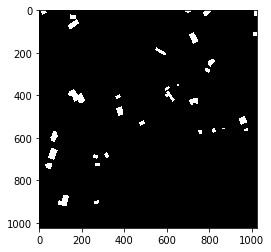

In [18]:
arr = generate_mask(os.path.join(xview_train_img_dir,"midwest-flooding_00000181_post_disaster.png"),
                 os.path.join(xview_train_json_dir,"midwest-flooding_00000181_post_disaster.json"),
                 "mask1.tif")
plt.imshow(arr, cmap="gray")

In [ ]:
arr = generate_mask_damage(os.path.join(xview_train_img_dir,"midwest-flooding_00000181_post_disaster.png"),
                 os.path.join(xview_train_json_dir,"midwest-flooding_00000181_post_disaster.json"),
                 "mask1.png")
plt.imshow(arr, cmap="gray")

In [ ]:
def get_mask_filename(name):
    return name.replace(".png","_mask.png")

for (dirpath, dirspath, filenames) in os.walk(xview_train_img_dir):
    for fn in filenames:
        mask_fn=get_mask_filename(fn)
        json_fn = fn.replace(".png",".json")
        print(mask_fn)
        generate_mask(os.path.join(dirpath, fn),
                      os.path.join(xview_train_json_dir, json_fn),
                      os.path.join(xview_train_mask_dir, mask_fn))
                      

In [ ]:
fns = os.listdir(xview_train_img_dir)
print(len(fns))

## Loading the mask back ##

In [20]:
Image.open("mask1.tif").convert("L").save("mask1bw.tif")

(1024, 1024)


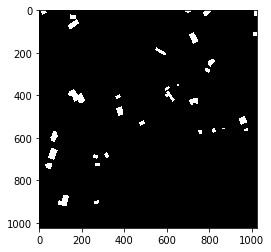

In [22]:
image = Image.open("mask1bw.tif")
im_arr=np.asarray(image)
print(im_arr.shape)
plt.imshow(im_arr,cmap="gray")

## Generating Masks in Grayscale TIF ##

In [9]:
img_path = "C:/data/xview2/train/combine"
for (dirpath, dirspath, filenames) in os.walk(img_path):
    for fn in filenames:
        mask_fn=fn.replace(".png","_mask.tif")
        json_fn = fn.replace(".png",".json")
        print(mask_fn)
        generate_mask_bw(os.path.join(dirpath, fn),
                      os.path.join(xview_train_json_dir, json_fn),
                      os.path.join(dirpath, mask_fn))

guatemala-volcano_00000000_post_disaster_mask.tif
guatemala-volcano_00000000_pre_disaster_mask.tif
guatemala-volcano_00000001_post_disaster_mask.tif
guatemala-volcano_00000001_pre_disaster_mask.tif
guatemala-volcano_00000002_post_disaster_mask.tif
guatemala-volcano_00000002_pre_disaster_mask.tif
guatemala-volcano_00000006_post_disaster_mask.tif
guatemala-volcano_00000006_pre_disaster_mask.tif
guatemala-volcano_00000007_post_disaster_mask.tif
guatemala-volcano_00000007_pre_disaster_mask.tif
guatemala-volcano_00000008_post_disaster_mask.tif
guatemala-volcano_00000008_pre_disaster_mask.tif
guatemala-volcano_00000010_post_disaster_mask.tif
guatemala-volcano_00000010_pre_disaster_mask.tif
guatemala-volcano_00000013_post_disaster_mask.tif
guatemala-volcano_00000013_pre_disaster_mask.tif
guatemala-volcano_00000015_post_disaster_mask.tif
guatemala-volcano_00000015_pre_disaster_mask.tif
guatemala-volcano_00000016_post_disaster_mask.tif
guatemala-volcano_00000016_pre_disaster_mask.tif
guatemala-